In [70]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [71]:
path = untar_data(URLs.ML_100k)

### Preprocessing Our Data

In [72]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [73]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [74]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [75]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


In [76]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [77]:
one_hot_3 = one_hot(3, n_users).float()

In [78]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

### Collaborative Filtering From Scratch

In [79]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [80]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [81]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [82]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882039,0.946304,00:10
1,0.654607,0.887440,00:10
2,0.515019,0.870116,00:10
3,0.452395,0.855182,00:10
4,0.431676,0.849766,00:09


### Interpreting Our Model

In [83]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Grease 2 (1982)',
 'Children of the Corn: The Gathering (1996)',
 'Bloodsport 2 (1995)',
 'Cable Guy, The (1996)']

In [84]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Rear Window (1954)']

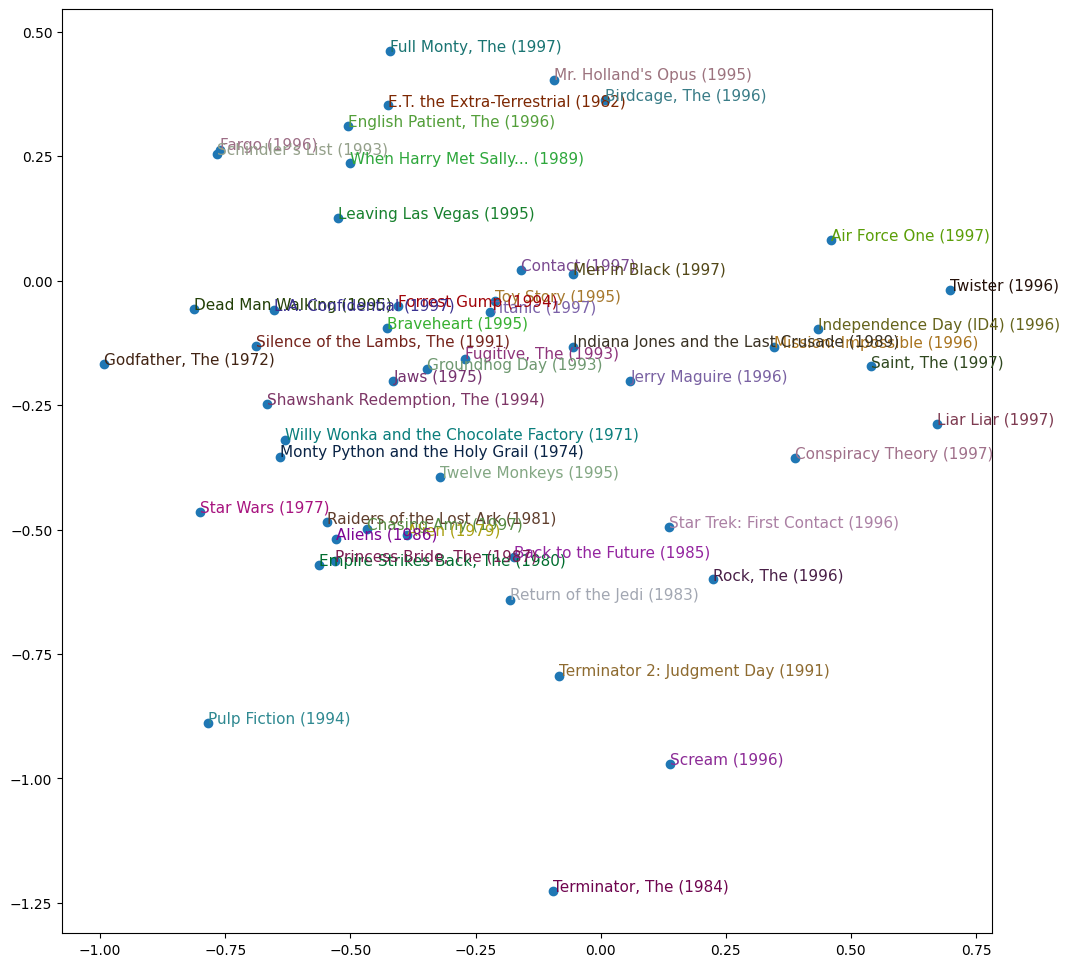

In [85]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()